# BLU06 - Learning Notebook - Part 2 of 3 - Time Series Preprocessing and Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import utils

plt.rcParams['figure.figsize'] = (12, 4.2)

In the previous notebook we learned how to formulate time series multi-step forecasting as a regression problem where any ML regression model can be applied. In this notebook we'll learn how to engineer more features and explore grid search as a way to select the features necessary for a good forecast.

## 1. Data preprocessing

We'll use a dataset with daily customer numbers for a store. In this section, we go through the usual preprocessing moves for time series data.

Let's look at our data:

In [2]:
store = utils.get_store_one_data()
store.head()

,customers
date,
2013-01-02,2111
2013-01-03,1833
2013-01-04,1863
2013-01-05,1509
2013-01-06,520


The index is already set and sorted and it seems to have a daily frequency. 

It's always important to verify that the data has all the timestamps. To make sure that we have don't miss any dates we can resample the data to a daily frequency which will add all possibly non-existing days as NaNs. Then we check the null values.

In [3]:
store_resampled = store.resample('D').asfreq()
store_resampled.isnull().sum()

customers    11
dtype: int64

Ok! So there were 11 missing days. Let's check which days where these:

In [4]:
store_resampled[store_resampled.isnull()['customers']]

,customers
date,
2013-12-25,NaN
2014-01-01,NaN
2014-12-25,NaN
2015-01-01,NaN
2015-07-07,NaN
2015-12-25,NaN
2016-01-01,NaN
2016-01-02,NaN
2016-01-03,NaN


Interesting! During Christmas and New Year the store should be closed, hence why there is no entry for the number of customers. Since we have no extra information regarding the other days we'll assume that the store was also closed. So we have to replace these NaNs with 0s.

In [5]:
store_cleaned = store_resampled.fillna(0)
store_cleaned.isnull().sum()

customers    0
dtype: int64

Let's also plot the data.

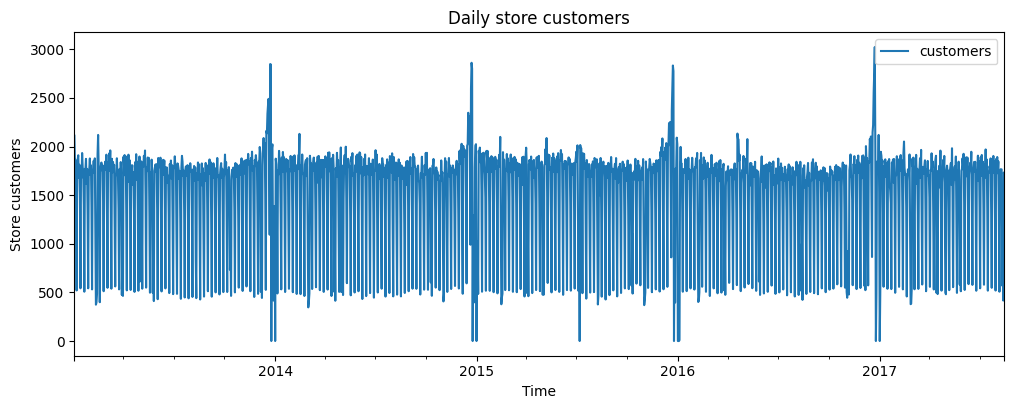

In [6]:
store_cleaned.plot(label="original data")
plt.ylabel('Store customers')
plt.xlabel('Time')
plt.title('Daily store customers')
plt.legend();

Oh, that's a lot of data and it seems to have some yearly periodicity. Let's plot just one year to see the details.

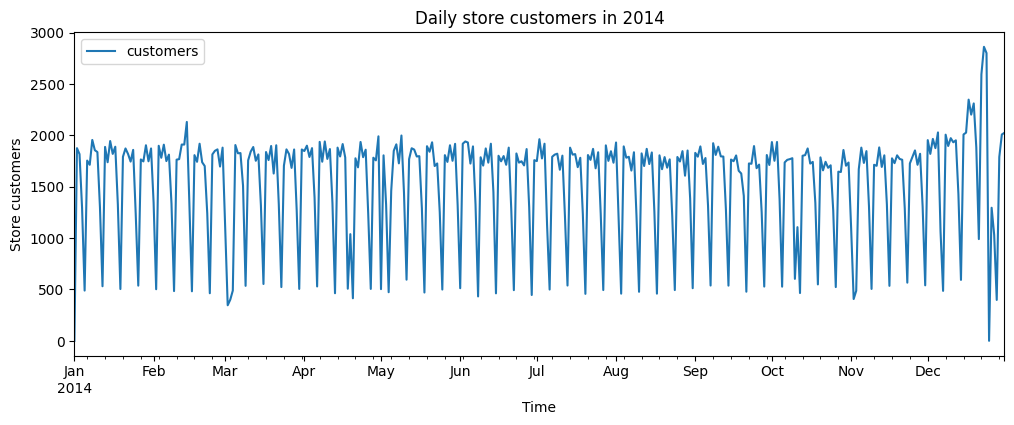

In [7]:
store_cleaned.loc['2014'].plot(label="original data")
plt.ylabel('Store customers')
plt.xlabel('Time')
plt.title('Daily store customers in 2014')
plt.legend();

Allright, now we see the details. It looks like a weekly seasonal data with no apparent trend and a small surge in December which makes sense for store customer numbers.

## 2. Feature Engineering

In the last BLU we used the simplest feature to predict time series: lags. But there's a lot more you can do! 

First let's see what a model with just lags can do, similar to what we did in the last notebook. We use the function from the last notebook which we conveniently stored in the utils file (and expanded a little).

In [8]:
# we create train and test set for this purpose
split_date = '2017-6'
train = store_cleaned.loc[store_cleaned.index < split_date]
test = store_cleaned.loc[store_cleaned.index >= split_date]

forecast = utils.multistep_forecast(train.customers, model=LinearRegression(), num_lags=30,
                              num_periods_ahead=len(test.customers))

30 day lags cover the past values for about a month, this could work. This is the result and the MAE.

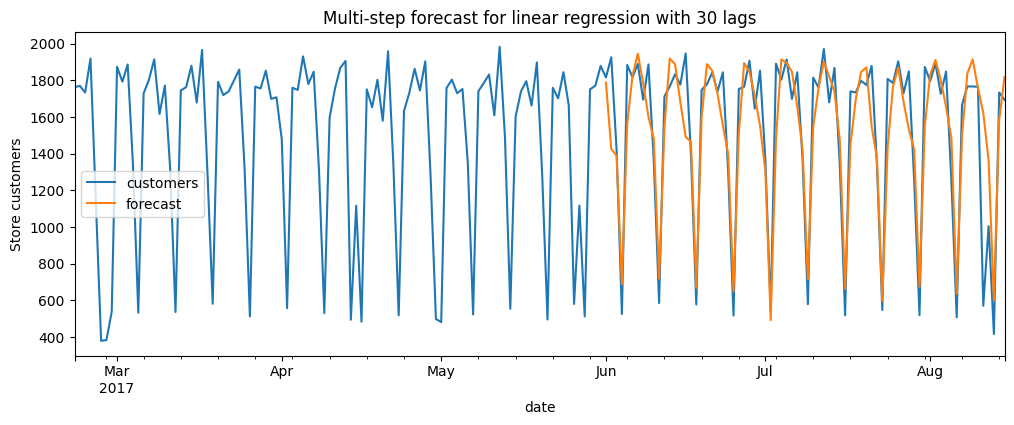

In [9]:
store[1500:].plot(label="original data")
plt.ylabel('Store customers')
pd.Series(forecast, index=test.index).plot(label="forecast")
plt.title('Multi-step forecast for linear regression with 30 lags')
plt.legend();

In [10]:
mean_absolute_error(test,forecast)

154.90308385316635

A pretty good baseline. Let's see if we can do better with adding more features.

### 2.1 Diffs

Similar to lags, we can also use diffs of the time series as features. Knowing the daily changes in the values could help forecast future values, especially with trending time series.

In [11]:
store_cleaned.diff(1)

,customers
date,
2013-01-02,NaN
2013-01-03,-278.0
2013-01-04,30.0
2013-01-05,-354.0
2013-01-06,-989.0
...,...
2017-08-11,-1194.0
2017-08-12,434.0
2017-08-13,-588.0


We can use the following function to add as many diffs as we want:

In [12]:
def build_diffed_features(df, original, num_diffs): 
    """
    Adds new features to df from diffs of the original time series.
    """
    df_ = df.copy()
    for i in range(1, num_diffs+1):
        df_['diff_%s' % str(i)] = original.diff(i)
    return df_

For now, we add just one diff.

In [13]:
store_features = store_cleaned.copy()
store_features = build_diffed_features(store_features, store_cleaned, 1)

In [14]:
store_features.head()

,customers,diff_1
date,,
2013-01-02,2111.0,NaN
2013-01-03,1833.0,-278.0
2013-01-04,1863.0,30.0
2013-01-05,1509.0,-354.0
2013-01-06,520.0,-989.0


### 2.2 Rolling window features

Another type of feature that may be relevant are rolling window features. As you may recall, a rolling window refers to an interval of timepoints before the current timepoint. From that window, we can extract features such as the minimum, mean, maximum and standard deviation which will convey information about the recent statistical properties of the time series to the model. These features can also help model a trend.

Here is the rolling maximum with a seven day window. A weekly window makes sense given the seasonality of this data.

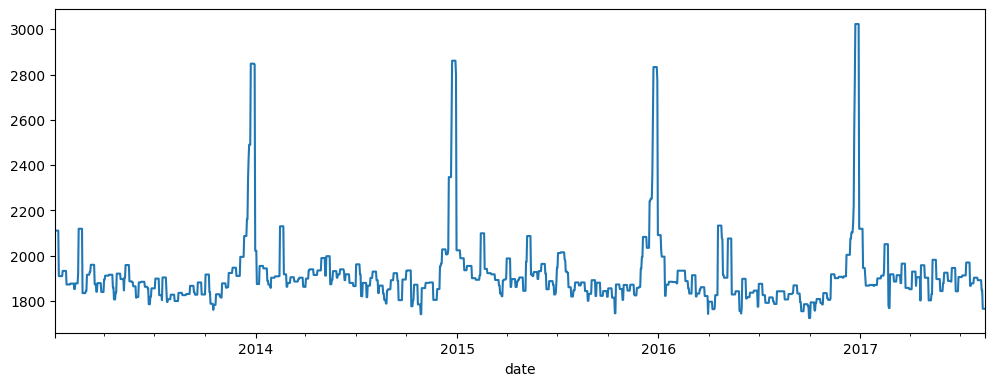

In [15]:
store_features['customers'].rolling('7D').max().plot();

We'll use the following function to add rolling window statistics to the dataset.

In [16]:
def build_rolling_features(df, original, rolling=[], rolling_freq='7D'):
    """
    Adds new features to df from rolling window statistics
    such as max, min, mean, std.
    """
    df_ = df.copy()
    for stat in rolling:
        df_['rolling_%s'%str(stat)] = original.rolling(rolling_freq).aggregate(stat)
    return df_

In [17]:
store_features = build_rolling_features(store_features, store_cleaned, ['max','min','mean','std'])
store_features.head()

,customers,diff_1,rolling_max,rolling_min,rolling_mean,rolling_std
date,,,,,,
2013-01-02,2111.0,NaN,2111.0,2111.0,2111.000000,NaN
2013-01-03,1833.0,-278.0,2111.0,1833.0,1972.000000,196.575685
2013-01-04,1863.0,30.0,2111.0,1833.0,1935.666667,152.582218
2013-01-05,1509.0,-354.0,2111.0,1509.0,1829.000000,247.046554
2013-01-06,520.0,-989.0,2111.0,520.0,1567.200000,623.273776


Nice, the feature set is growing, let's see what else we have in store.

### 2.3 Datetime features

Datetime features refer to those you can extract simply from the timestamp. Which day of the week it is, which month, etc. can go a long way to help the model to better understand the seasonality in the time series.

We can also create features representing days when the store is closed, like Christmas and the New Year. We'll create the holidays feature for this purpose using the function below.

In [18]:
def build_holiday_features(df, holidays=True):
    """
    Builds holidays categorical feature.
    """
    df_ = df.copy()
    if holidays:
        holidays = (((df_.index.month==12) & (df_.index.day==25))
              |((df_.index.month==1) & (df_.index.day==1))) + 0 # +0 to convert bool to int
        df_['holidays'] = pd.Series(holidays, index=df_.index)
    return df_

In [19]:
store_features = build_holiday_features(store_features)
store_features.head()

,customers,diff_1,rolling_max,rolling_min,rolling_mean,rolling_std,holidays
date,,,,,,,
2013-01-02,2111.0,NaN,2111.0,2111.0,2111.000000,NaN,0
2013-01-03,1833.0,-278.0,2111.0,1833.0,1972.000000,196.575685,0
2013-01-04,1863.0,30.0,2111.0,1833.0,1935.666667,152.582218,0
2013-01-05,1509.0,-354.0,2111.0,1509.0,1829.000000,247.046554,0
2013-01-06,520.0,-989.0,2111.0,520.0,1567.200000,623.273776,0


Now we could add the day of the week and month features using the datetime index [properties](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html). Let's see how that goes.

In [20]:
store_features.index.weekday, store_features.index.month

(Index([2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
        ...
        6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
       dtype='int32', name='date', length=1687),
 Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        ...
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
       dtype='int32', name='date', length=1687))

Regarding the day of the week encoding, you can check pandas [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.dayofweek.html). Basically, Monday is 0 and Sunday is 6. But this brings a good point, is Monday closer to Sunday than to Thursday? "Of course it is closer, what kind of question is that?!" 

Well, the issue is that the current mapping between the days of the week and the numbers is the following:

- Monday: 0
- Thursday: 3
- Sunday: 6

This means that the distance between Monday and Thursday is smaller than the distance from Monday to Sunday, which gives a wrong intuition to the model. This is particularly important for linear models, as well as kNN, k-means and neural networks. We'll have to find a way to encode these features that conveys their cyclical nature to the model. Another option are dummy variables as explained [here](https://otexts.com/fpp3/useful-predictors.html#dummy-variables). Just don't fall into the dummy variable trap!

<img src="media/trap.jpg" width="400">

### 2.4 Circular encoding

So how can we encode features while maintaining their cyclical nature? We can use circular encoding with the periodic sine and cosine functions.

If we evenly distribute the feature values on a unit circle, as the hours on the clock face, each point will be defined by two coordinates. These coordinates are given by the sine and the cosine of the angle of the point on the circle. For a more detailed explanation, check out the optional notebook of this BLU. For now look at this plot of the date against the sine of the weekday in January 2014:

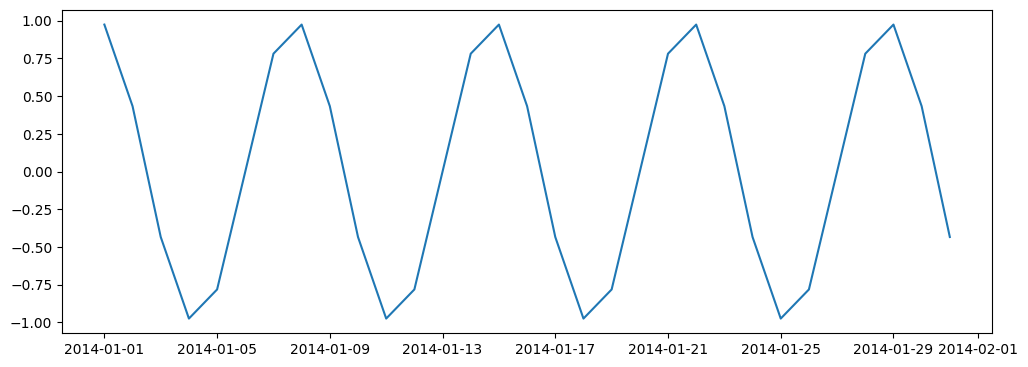

In [21]:
plt.plot(store_features.loc['2014 01'].index, np.sin(2*np.pi*store_features.loc['2014 01'].index.weekday/7));

Basically, one cycle of the sine is one week and the same happens for the cosine.

We will encode both days and months into cyclical features using the following function.

In [22]:
def build_cyclical_features(df, weekday=False, month=False):
    """
    Build cyclical weekday and month features.
    """
    df_ = df.copy()
    if weekday == True:
        df_['sin_weekday'] = np.sin(2*np.pi*df_.index.weekday/7)
        df_['cos_weekday'] = np.cos(2*np.pi*df_.index.weekday/7)      
    if month == True:
        df_['sin_month'] = np.sin(2*np.pi*df_.index.month/12)
        df_['cos_month'] = np.cos(2*np.pi*df_.index.month/12)
    return df_    

In [23]:
store_features = build_cyclical_features(store_features, weekday=True, month=True)

So our dataframe has a couple more features now:

In [24]:
store_features.head()

,customers,diff_1,rolling_max,rolling_min,rolling_mean,rolling_std,holidays,sin_weekday,cos_weekday,sin_month,cos_month
date,,,,,,,,,,,
2013-01-02,2111.0,NaN,2111.0,2111.0,2111.000000,NaN,0,0.974928,-0.222521,0.5,0.866025
2013-01-03,1833.0,-278.0,2111.0,1833.0,1972.000000,196.575685,0,0.433884,-0.900969,0.5,0.866025
2013-01-04,1863.0,30.0,2111.0,1833.0,1935.666667,152.582218,0,-0.433884,-0.900969,0.5,0.866025
2013-01-05,1509.0,-354.0,2111.0,1509.0,1829.000000,247.046554,0,-0.974928,-0.222521,0.5,0.866025
2013-01-06,520.0,-989.0,2111.0,520.0,1567.200000,623.273776,0,-0.781831,0.623490,0.5,0.866025


With domain knowledge you can add even more features, such as: is it a holiday? is there a special Event? Even the weather! Feature engineering has a lot to do with creativity and thinking outside of the box. 

So let's see if any of these fancy new features improves our model. We will test that with a grid search over different parameter combinations.

## 3. Grid search

First, we define a function that creates any features from the previous section for us.

In [25]:
def build_features(df, original, num_lags=1, num_diffs=0, weekday=False, month=False,
                   rolling=[], rolling_freq='7D', holidays=False): 
    """
    Builds features for time series regression.
    """
    df_ = df.copy()
    df_ = build_lagged_features(df_, original, num_lags)
    df_ = build_diffed_features(df_, original, num_diffs)
    df_ = build_rolling_features(df_, original, rolling, rolling_freq)
    df_ = build_cyclical_features(df_, weekday, month)
    df_ = build_holiday_features(df_, holidays)        
    return df_

Now we should set up models for all parameter combinations and see how they perform on the test set, but that would be too many models. We're going to test just a few combinations.

We create a parameter grid with the combinations we want to test using sklearn's [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html). We will assume that the rolling statistics and the holidays always improve the model, so we use just one value for those. Feel free to add more options to the parameter grid if you want to experiment.

Note that we're also testing two models, the plain vanilla linear regression and the gradient boosting regressor model.

In [26]:
param_grid = {'model': [LinearRegression(), GradientBoostingRegressor(random_state=10)], 
              'num_lags':np.arange(1,3),
              'num_diffs':np.arange(0,3),
              'weekday':[True,False],
              'month':[True,False],
              'holidays': [True],
              'rolling' : [['mean','min','max','std']]
             }

grid = ParameterGrid(param_grid)

We will create a train, validation, and a test set so that we can tune the model on the validation set before testing it on the test set. The performance on the validation set is measured with the MAE.

In [27]:
val_split_date = '2017-3'
test_split_date = '2017-6'
train = store_cleaned.loc[store_cleaned.index < val_split_date]
val = store_cleaned.loc[(val_split_date <= store_cleaned.index) & (store_cleaned.index < test_split_date)]
test = store_cleaned.loc[store_cleaned.index >= test_split_date]

We could use a simple loop to test all the parameter combinations, but a faster option is to use the `joblib` library which parallelizes the code.

In [28]:
%%time 
# This still takes a few minutes to run.

def wrap_model_selection(params): 
    predictions = utils.multistep_forecast(original=train, 
                                     model=params['model'], 
                                     num_lags=params['num_lags'],
                                     num_diffs=params['num_diffs'],
                                     weekday=params['weekday'],
                                     month=params['month'],
                                     rolling=params['rolling'],
                                     holidays=params['holidays'],
                                     num_periods_ahead=len(val), target='target')
    return params,mean_absolute_error(val,predictions)

grid_search_result = Parallel(n_jobs=-1)(delayed(wrap_model_selection)(params=params) 
                          for params in tqdm(grid))

  0%|          | 0/48 [00:00<?, ?it/s]

CPU times: user 1.69 s, sys: 417 ms, total: 2.11 s
Wall time: 10min 27s


These are the results:

In [29]:
df_cv = pd.DataFrame(grid_search_result, columns=['params','mae']).sort_values('mae')
df_cv.head()

,params,mae
38,"{'holidays': True, 'model': ([DecisionTreeRegr...",121.461920
26,"{'holidays': True, 'model': ([DecisionTreeRegr...",122.967953
30,"{'holidays': True, 'model': ([DecisionTreeRegr...",124.047228
28,"{'holidays': True, 'model': ([DecisionTreeRegr...",129.235199
42,"{'holidays': True, 'model': ([DecisionTreeRegr...",130.116387


Let's inspect our best model a bit better:

In [30]:
df_cv.iloc[0].params

{'holidays': True,
 'model': GradientBoostingRegressor(random_state=10),
 'month': False,
 'num_diffs': 0,
 'num_lags': 2,
 'rolling': ['mean', 'min', 'max', 'std'],
 'weekday': True}

It has the weekday feature reflecting the seasonality, the lags, and the gradient boosting regressor which seems to work better than the vanilla linear regression.

A close second is this parameter combination with the additional month feature. Maybe because as we've seen in the very first plot at the top of the notebook, not all months are equal.

In [31]:
df_cv.iloc[1].params

{'holidays': True,
 'model': GradientBoostingRegressor(random_state=10),
 'month': True,
 'num_diffs': 0,
 'num_lags': 2,
 'rolling': ['mean', 'min', 'max', 'std'],
 'weekday': True}

## 4. Testing

Now we can finally test the best parameters on the test set and see if the forecast improved compared to our baseline without feature engineering. But first we need to append the validation set to the training set

In [32]:
train = pd.concat([train,val])

In [33]:
best_params = df_cv.iloc[0].params

forecast = utils.multistep_forecast(train, 
                              model=best_params['model'],
                              num_lags=best_params['num_lags'],
                              num_diffs=best_params['num_diffs'],
                              weekday=best_params['weekday'],
                              month=best_params['month'],
                              rolling=best_params['rolling'],
                              holidays=best_params['holidays'],
                              num_periods_ahead=len(test))

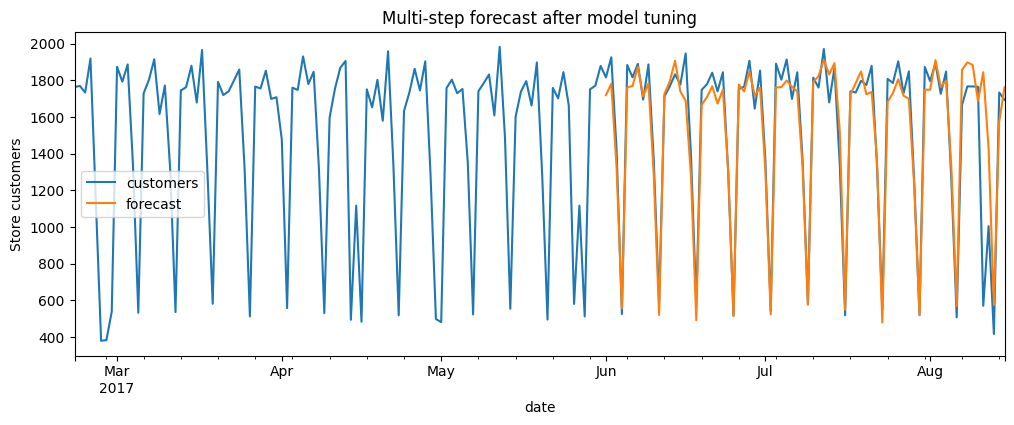

In [34]:
store[1500:].plot(label="original data")
plt.ylabel('Store customers')
pd.Series(forecast, index=test.index).plot(label="forecast")
plt.title('Multi-step forecast after model tuning')
plt.legend();

In [35]:
mean_absolute_error(test,forecast)

93.39275718723671

Wow, that's a big improvement from the non-feature-engineered model. Notice that especially the peaks and troughs of the data were captured much better. Feature engineering works!

It's interesting that the MAE is lower on the test set than on the val set. This may go a bit against your expectations. Since we did the tunning on the val set we would expect it to perform better there. But that doesn't happen. Remember when we talked about stationarity in the last BLU? Well, we'll talk about it again in the next notebook.

## 5. Further reading

Check out these two section about time related feature engineering from [sklearn](https://scikit-learn.org/1.5/auto_examples/applications/plot_cyclical_feature_engineering.html#time-related-feature-engineering) and [Hyndman & Athanasopoulos](https://otexts.com/fpp3/useful-predictors.html).